## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [16]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(input_layer)
            x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
    output_layer = keras.layers.Dense(units=output_units,
                                      activation='softmax',
                                      name='output')(x)
    model = keras.models.Model(inputs=[input_layer],
                               outputs=[output_layer])
    return model

In [17]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [18]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.1, 0.05]
redice_lr_patient = [5, 3, 0]

In [20]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                  min_lr=1e-12,
                                  monitor='val_loss',
                                  patience=reduce_patient,
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.3122 - accuracy: 0.5439 - val_loss: 1.4820 - val_accuracy: 0.4731
Epoch 12/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.2894 - accuracy: 0.5524 - val_loss: 1.4683 - val_accuracy: 0.4812
Epoch 13/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.2676 - accuracy: 0.5597 - val_loss: 1.4746 - val_accuracy: 0.4780
Epoch 14/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.2470 - accuracy: 0.5676 - val_loss: 1.4707 - val_accuracy: 0.4838
Epoch 15/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.2273 - accuracy: 0.5749 - val_loss: 1.4738 - val_accuracy: 0.4818

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 16/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.2013 - accuracy: 0.5851 - val_loss: 1.4622 - val_accuracy: 0.4869
Epoch 17/25
50000/50000 [======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 72us/step - loss: 2.6138 - accuracy: 0.1808 - val_loss: 2.2088 - val_accuracy: 0.1758
Epoch 2/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.0585 - accuracy: 0.3012 - val_loss: 2.1042 - val_accuracy: 0.2585
Epoch 3/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.8927 - accuracy: 0.3462 - val_loss: 2.0018 - val_accuracy: 0.2979
Epoch 4/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.8067 - accuracy: 0.3737 - val_loss: 1.8855 - val_accuracy: 0.3346
Epoch 5/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.7465 - accuracy: 0.3923 - val_loss: 1.7999 - val_accuracy: 0.3665
Epoch 6/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.7000 - accuracy: 0.4067 - val_loss: 1.7475 - val_accuracy: 0.3833
Epoch 7/25
50000/50000 [==============================] - 3s 62us/st

Epoch 21/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.4123 - accuracy: 0.5083 - val_loss: 1.5684 - val_accuracy: 0.4526
Epoch 22/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.4013 - accuracy: 0.5125 - val_loss: 1.5628 - val_accuracy: 0.4500
Epoch 23/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.3916 - accuracy: 0.5170 - val_loss: 1.5562 - val_accuracy: 0.4557
Epoch 24/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.3812 - accuracy: 0.5195 - val_loss: 1.5521 - val_accuracy: 0.4545
Epoch 25/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.3719 - accuracy: 0.5245 - val_loss: 1.5481 - val_accuracy: 0.4575
Numbers of exp: 5, reduce_factor: 0.10, reduce_patient: 0
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)            

Epoch 6/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.6913 - accuracy: 0.4123 - val_loss: 1.7448 - val_accuracy: 0.3794
Epoch 7/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.6546 - accuracy: 0.4236 - val_loss: 1.7034 - val_accuracy: 0.3944
Epoch 8/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.6225 - accuracy: 0.4354 - val_loss: 1.6764 - val_accuracy: 0.4081
Epoch 9/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.5953 - accuracy: 0.4429 - val_loss: 1.6598 - val_accuracy: 0.4098
Epoch 10/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.5733 - accuracy: 0.4501 - val_loss: 1.6438 - val_accuracy: 0.4189
Epoch 11/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.5509 - accuracy: 0.4569 - val_loss: 1.6362 - val_accuracy: 0.4229
Epoch 12/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.5330 - accuracy: 0.4655 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 73us/step - loss: 2.4666 - accuracy: 0.2082 - val_loss: 2.2043 - val_accuracy: 0.1540
Epoch 2/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.0339 - accuracy: 0.3096 - val_loss: 2.1108 - val_accuracy: 0.2202
Epoch 3/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.8847 - accuracy: 0.3480 - val_loss: 1.9971 - val_accuracy: 0.2820
Epoch 4/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.8021 - accuracy: 0.3740 - val_loss: 1.8845 - val_accuracy: 0.3349
Epoch 5/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.7446 - accuracy: 0.3919 - val_loss: 1.8100 - val_accuracy: 0.3580
Epoch 6/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.6996 - accuracy: 0.4074 - val_loss: 1.7576 - val_accuracy: 0.3795
Epoch 7/25
50000/50000 [==============================] - 3s 65us/st

50000/50000 [==============================] - 3s 69us/step - loss: 0.4678 - accuracy: 0.8549 - val_loss: 1.6159 - val_accuracy: 0.5120
Epoch 21/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.4347 - accuracy: 0.8657 - val_loss: 1.7545 - val_accuracy: 0.4968
Epoch 22/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.4132 - accuracy: 0.8746 - val_loss: 1.7453 - val_accuracy: 0.4955

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 23/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.3468 - accuracy: 0.9038 - val_loss: 1.6581 - val_accuracy: 0.5186
Epoch 24/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.3160 - accuracy: 0.9195 - val_loss: 1.6494 - val_accuracy: 0.5240
Epoch 25/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.2994 - accuracy: 0.9256 - val_loss: 1.7228 - val_accuracy: 0.5187
Numbers of exp: 10, reduce_factor: 0.50, re

50000/50000 [==============================] - 3s 66us/step - loss: 1.7474 - accuracy: 0.3928 - val_loss: 2.0017 - val_accuracy: 0.2988
Epoch 3/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.6524 - accuracy: 0.4251 - val_loss: 1.8456 - val_accuracy: 0.3712
Epoch 4/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.5919 - accuracy: 0.4448 - val_loss: 1.7282 - val_accuracy: 0.4066
Epoch 5/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.5504 - accuracy: 0.4583 - val_loss: 1.6599 - val_accuracy: 0.4218
Epoch 6/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.5149 - accuracy: 0.4713 - val_loss: 1.6234 - val_accuracy: 0.4274
Epoch 7/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.4866 - accuracy: 0.4825 - val_loss: 1.6015 - val_accuracy: 0.4313
Epoch 8/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4638 - accuracy: 0.4889 - val_loss: 1.5814 - val

50000/50000 [==============================] - 4s 70us/step - loss: 1.2675 - accuracy: 0.5657 - val_loss: 1.4888 - val_accuracy: 0.4844
Epoch 23/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.2576 - accuracy: 0.5692 - val_loss: 1.4873 - val_accuracy: 0.4827
Epoch 24/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.2489 - accuracy: 0.5718 - val_loss: 1.4875 - val_accuracy: 0.4808
Epoch 25/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.2395 - accuracy: 0.5731 - val_loss: 1.4841 - val_accuracy: 0.4859
Numbers of exp: 13, reduce_factor: 0.10, reduce_patient: 3
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_____________

Epoch 7/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4889 - accuracy: 0.4775 - val_loss: 1.5863 - val_accuracy: 0.4456
Epoch 8/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4649 - accuracy: 0.4873 - val_loss: 1.5641 - val_accuracy: 0.4480
Epoch 9/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4429 - accuracy: 0.4960 - val_loss: 1.5600 - val_accuracy: 0.4534
Epoch 10/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4237 - accuracy: 0.5025 - val_loss: 1.5500 - val_accuracy: 0.4598
Epoch 11/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4058 - accuracy: 0.5109 - val_loss: 1.5388 - val_accuracy: 0.4579
Epoch 12/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.3904 - accuracy: 0.5155 - val_loss: 1.5365 - val_accuracy: 0.4582
Epoch 13/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.3757 - accuracy: 0.5205 - val_los

Epoch 23/25
50000/50000 [==============================] - 4s 73us/step - loss: 3.1916 - accuracy: 0.0817 - val_loss: 3.2104 - val_accuracy: 0.0817
Epoch 24/25
50000/50000 [==============================] - 4s 73us/step - loss: 3.1901 - accuracy: 0.0815 - val_loss: 3.2107 - val_accuracy: 0.0818
Epoch 25/25
50000/50000 [==============================] - 4s 73us/step - loss: 3.1913 - accuracy: 0.0817 - val_loss: 3.2109 - val_accuracy: 0.0818
Numbers of exp: 16, reduce_factor: 0.05, reduce_patient: 3
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_59 (Batc (None, 256)               1024      
_________________

Epoch 8/25
50000/50000 [==============================] - 4s 75us/step - loss: 3.1632 - accuracy: 0.0868 - val_loss: 2.8783 - val_accuracy: 0.0867
Epoch 9/25
50000/50000 [==============================] - 4s 75us/step - loss: 3.1633 - accuracy: 0.0877 - val_loss: 2.9392 - val_accuracy: 0.0869
Epoch 10/25
50000/50000 [==============================] - 4s 75us/step - loss: 3.1632 - accuracy: 0.0860 - val_loss: 2.9906 - val_accuracy: 0.0868
Epoch 11/25
50000/50000 [==============================] - 4s 75us/step - loss: 3.1639 - accuracy: 0.0857 - val_loss: 3.0337 - val_accuracy: 0.0883
Epoch 12/25
50000/50000 [==============================] - 4s 75us/step - loss: 3.1634 - accuracy: 0.0868 - val_loss: 3.0687 - val_accuracy: 0.0882
Epoch 13/25
50000/50000 [==============================] - 4s 75us/step - loss: 3.1639 - accuracy: 0.0862 - val_loss: 3.0969 - val_accuracy: 0.0889
Epoch 14/25
50000/50000 [==============================] - 4s 75us/step - loss: 3.1639 - accuracy: 0.0863 - val_lo

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.8501 - accuracy: 0.3630 - val_loss: 2.1248 - val_accuracy: 0.2076
Epoch 2/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.5538 - accuracy: 0.4558 - val_loss: 1.8802 - val_accuracy: 0.3493
Epoch 3/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.4420 - accuracy: 0.4923 - val_loss: 1.7631 - val_accuracy: 0.3813
Epoch 4/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.3589 - accuracy: 0.5231 - val_loss: 1.6687 - val_accuracy: 0.4166
Epoch 5/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.2933 - accuracy: 0.5468 - val_loss: 1.5919 - val_accuracy: 0.4258
Epoch 6/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.2444 - accuracy: 0.5668 - val_loss: 1.7504 - val_accuracy: 0.3924
Epoch 7/25
50000/50000 [==============================] - 3s 65us/st

50000/50000 [==============================] - 3s 64us/step - loss: 1.4590 - accuracy: 0.4923 - val_loss: 1.5966 - val_accuracy: 0.4379
Epoch 19/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.4446 - accuracy: 0.4963 - val_loss: 1.5985 - val_accuracy: 0.4436

Epoch 00019: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 20/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.4272 - accuracy: 0.5049 - val_loss: 1.5862 - val_accuracy: 0.4466
Epoch 21/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.4201 - accuracy: 0.5059 - val_loss: 1.5796 - val_accuracy: 0.4443
Epoch 22/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.4146 - accuracy: 0.5079 - val_loss: 1.5761 - val_accuracy: 0.4478
Epoch 23/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.4086 - accuracy: 0.5099 - val_loss: 1.5774 - val_accuracy: 0.4497

Epoch 00023: ReduceLROnPlateau reducing le

Epoch 2/25
50000/50000 [==============================] - 4s 76us/step - loss: 2.5854 - accuracy: 0.1746 - val_loss: 2.2762 - val_accuracy: 0.1545
Epoch 3/25
50000/50000 [==============================] - 4s 76us/step - loss: 2.4242 - accuracy: 0.2095 - val_loss: 2.2292 - val_accuracy: 0.1901
Epoch 4/25
50000/50000 [==============================] - 4s 77us/step - loss: 2.3123 - accuracy: 0.2358 - val_loss: 2.1696 - val_accuracy: 0.2201
Epoch 5/25
50000/50000 [==============================] - 4s 77us/step - loss: 2.2282 - accuracy: 0.2563 - val_loss: 2.1096 - val_accuracy: 0.2469
Epoch 6/25
50000/50000 [==============================] - 4s 77us/step - loss: 2.1626 - accuracy: 0.2732 - val_loss: 2.0606 - val_accuracy: 0.2655
Epoch 7/25
50000/50000 [==============================] - 4s 76us/step - loss: 2.1086 - accuracy: 0.2864 - val_loss: 2.0259 - val_accuracy: 0.2858
Epoch 8/25
50000/50000 [==============================] - 4s 76us/step - loss: 2.0638 - accuracy: 0.2988 - val_loss: 2

50000/50000 [==============================] - 4s 78us/step - loss: 1.7705 - accuracy: 0.3872 - val_loss: 1.8324 - val_accuracy: 0.3682
Epoch 23/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.7596 - accuracy: 0.3913 - val_loss: 1.8245 - val_accuracy: 0.3703
Epoch 24/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.7466 - accuracy: 0.3948 - val_loss: 1.8151 - val_accuracy: 0.3749
Epoch 25/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.7361 - accuracy: 0.3986 - val_loss: 1.8070 - val_accuracy: 0.3774
Numbers of exp: 24, reduce_factor: 0.05, reduce_patient: 5
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_____________

Epoch 7/25
50000/50000 [==============================] - 4s 84us/step - loss: 2.0856 - accuracy: 0.2919 - val_loss: 2.0107 - val_accuracy: 0.2819
Epoch 8/25
50000/50000 [==============================] - 4s 84us/step - loss: 2.0400 - accuracy: 0.3036 - val_loss: 1.9794 - val_accuracy: 0.2999
Epoch 9/25
50000/50000 [==============================] - 4s 84us/step - loss: 2.0003 - accuracy: 0.3146 - val_loss: 1.9597 - val_accuracy: 0.3128
Epoch 10/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.9660 - accuracy: 0.3248 - val_loss: 1.9465 - val_accuracy: 0.3192
Epoch 11/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.9350 - accuracy: 0.3332 - val_loss: 1.9297 - val_accuracy: 0.3287
Epoch 12/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.9097 - accuracy: 0.3403 - val_loss: 1.9175 - val_accuracy: 0.3337
Epoch 13/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.8853 - accuracy: 0.3469 - val_los

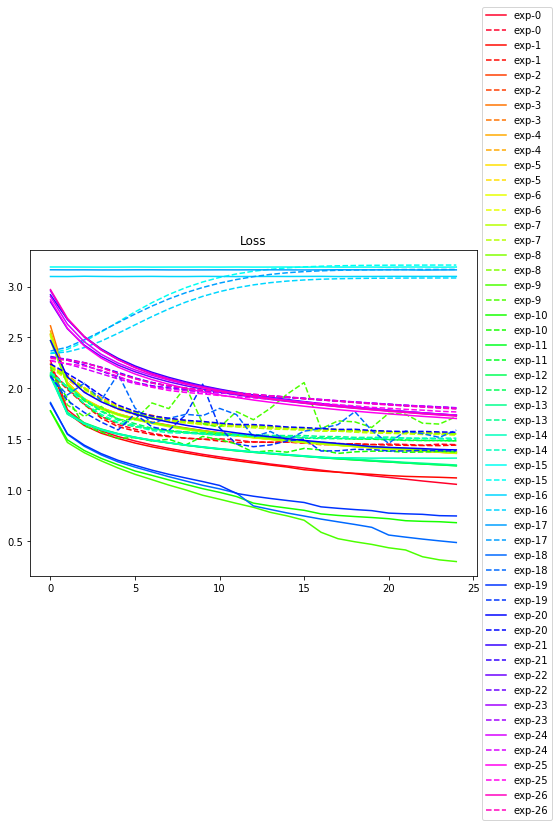

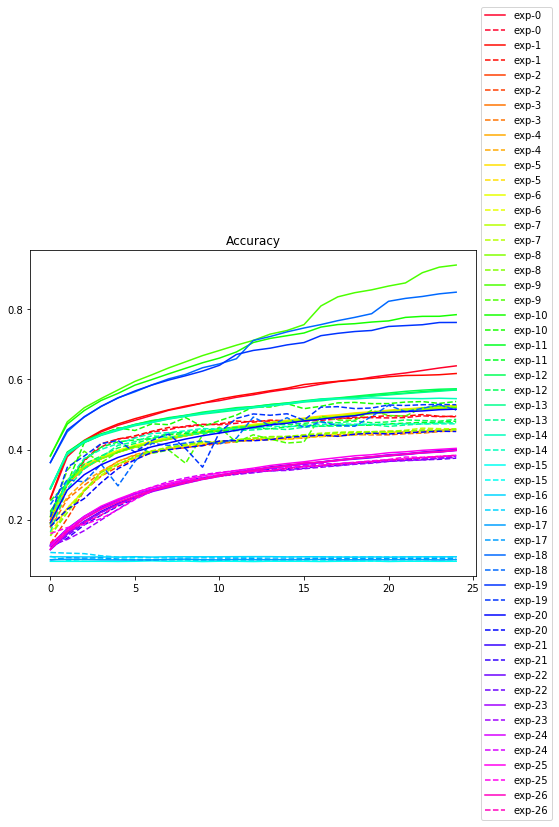

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()